=== RESULTADOS DA VALIDAÇÃO CRUZADA (k-fold = 10) ===
              Modelo  Acurácia Média  Desvio Padrão Média  F1-Score Média  \
0  Árvore de Decisão        0.734875             0.019259        0.733141   
1                SVM        0.731236             0.016223        0.730114   
2                KNN        0.613608             0.024607        0.609596   

   Desvio Padrão F1-Score  
0                0.019492  
1                0.016304  
2                0.024951  




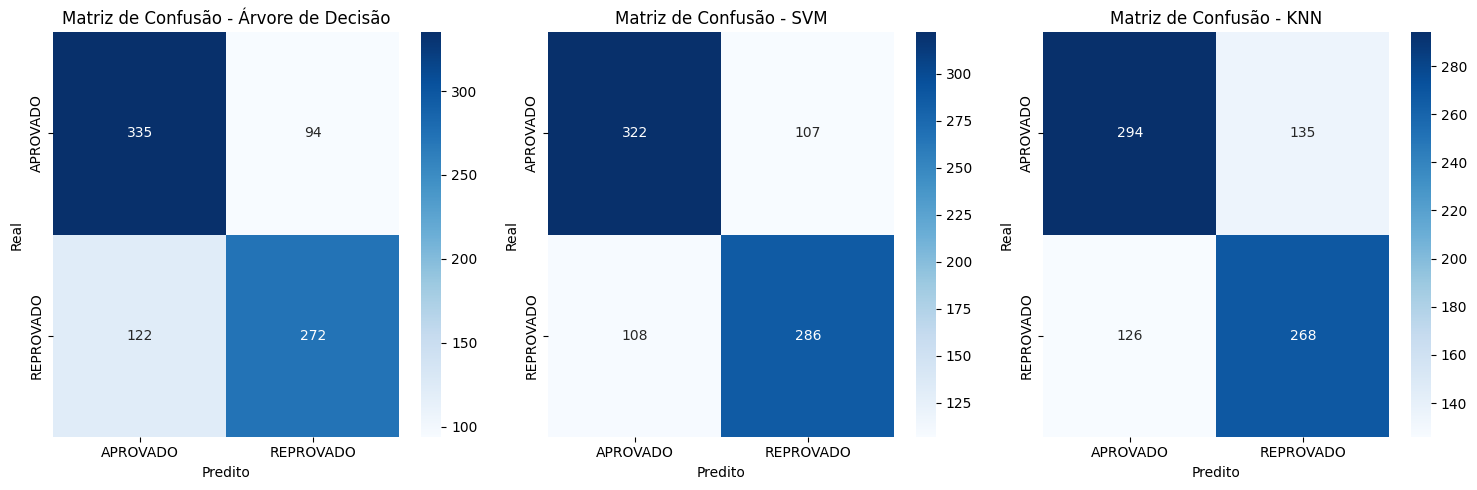

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ---------------------------------------------------------
# 1. CARREGAMENTO DOS DADOS
# ---------------------------------------------------------
df = pd.read_csv('/content/drive/MyDrive/Facom/Doutorado/dados_disciplinas_processed.csv', sep=',')

# ---------------------------------------------------------
# 2. PRÉ-PROCESSAMENTO
# ---------------------------------------------------------

# Converter 'disciplina_ja_cursada' de Booleano (False/True) para Inteiro (0/1)
df['disciplina_ja_cursada'] = df['disciplina_ja_cursada'].astype(int)

# Codificar o TARGET (APROVADO=0, REPROVADO=1 ou vice-versa)
le = LabelEncoder()
df['TARGET_COD'] = le.fit_transform(df['TARGET'])

# Definir Features (X) e Target (y)
# Removemos MATR_ALUNO (é apenas ID) e as colunas de Target originais
colunas_para_remover = ['MATR_ALUNO', 'TARGET', 'TARGET_COD']
X = df.drop(colunas_para_remover, axis=1)
y = df['TARGET_COD']

# Padronização (StandardScaler) (Z-SCORE)
# Importante: SVM e KNN são sensíveis à escala dos dados. Arvore não é, mas não atrapalha.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 3. CONFIGURAÇÃO DOS MODELOS
# ---------------------------------------------------------
modelos = {
    'Árvore de Decisão': DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=3),
    'SVM': SVC(kernel='linear', C=2.0),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# ---------------------------------------------------------
# 4. EXPERIMENTO A: Validação Cruzada (Para a Tabela de Resultados)
# ---------------------------------------------------------
print("=== RESULTADOS DA VALIDAÇÃO CRUZADA (k-fold = 10) ===")
resultados = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='accuracy')
    f1 = cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='f1_macro')

    resultados.append({
        'Modelo': nome,
        'Acurácia Média': scores.mean(),
        'Desvio Padrão Média': scores.std(),
        'F1-Score Média': f1.mean(),
        'Desvio Padrão F1-Score': f1.std()
    })

res_df = pd.DataFrame(resultados)
print(res_df)
print("\n" + "="*50 + "\n")

# ---------------------------------------------------------
# 5. EXPERIMENTO B: Matriz de Confusão (Hold-out 80/20)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

plt.figure(figsize=(15, 5))

for i, (nome, modelo) in enumerate(modelos.items()):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Predito')
    plt.ylabel('Real')

plt.tight_layout()
plt.show()

In [6]:
print(df.head())

   MATR_ALUNO   ANO  PERIODO  n_disciplinas_anteriores  \
0           1  2013        1                         0   
1           2  2013        1                         0   
2           3  2013        1                         0   
3           4  2013        2                         0   
4           4  2013        2                         0   

   taxa_aprovacao_historica  n_reprovacoes_historico  disciplina_ja_cursada  \
0                       0.5                        0                      0   
1                       0.5                        0                      0   
2                       0.5                        0                      0   
3                       0.5                        0                      0   
4                       0.5                        0                      0   

   n_vezes_disciplina  MEDIA_FINAL_PRED  NUM_FALTAS_PRED  disc_1  disc_2  \
0                   0         36.253373        13.990018       0       1   
1                   0   

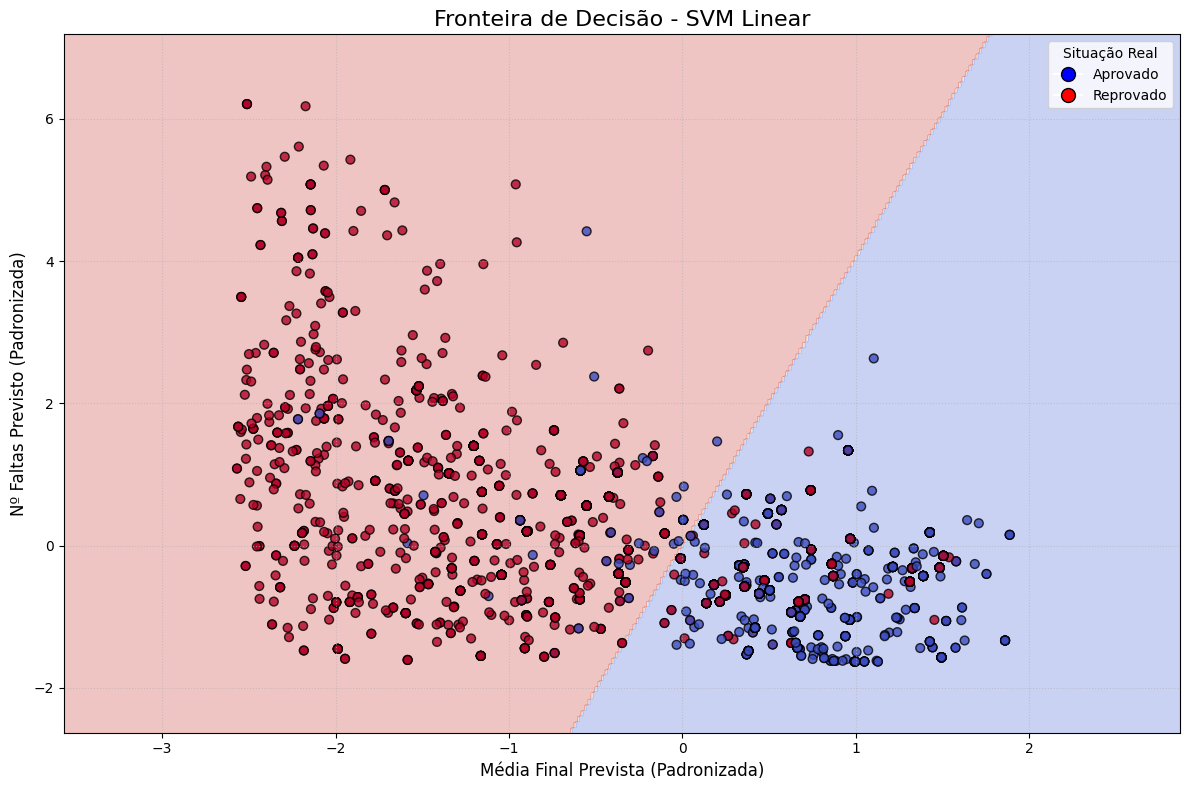

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# 2. PLOTAR APENAS O SVM LINEAR (COM MARGENS E SUPORTE)
# ==============================================================================

# A. Seleção de Dados (Apenas as 2 features principais)
cols_vis = ['MEDIA_FINAL_PRED', 'NUM_FALTAS_PRED']
X_vis = df[cols_vis].values
y_vis = df['TARGET_COD'].values

# B. Padronização
scaler_vis = StandardScaler()
X_vis_scaled = scaler_vis.fit_transform(X_vis)

# C. Treinar Modelo SVM Linear Exclusivo para Visualização
svm_linear = SVC(kernel='linear', C=2.0)
svm_linear.fit(X_vis_scaled, y_vis)

# D. Configurar Grade (Meshgrid)
h = .02
x_min, x_max = X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1
y_min, y_max = X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(12, 8))

# Prever fronteiras na grade
Z = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Desenhar contornos (Fundo colorido)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Desenhar os pontos reais (Alunos)
scatter = plt.scatter(X_vis_scaled[:, 0], X_vis_scaled[:, 1], c=y_vis,
                      cmap='coolwarm', edgecolor='k', s=40, alpha=0.8)

# Legenda
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Aprovado',
           markerfacecolor='blue', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Reprovado',
           markerfacecolor='red', markersize=10, markeredgecolor='k')
]

plt.legend(handles=legend_elements, loc='upper right', title="Situação Real")
plt.title("Fronteira de Decisão - SVM Linear", fontsize=16)
plt.xlabel('Média Final Prevista (Padronizada)', fontsize=12)
plt.ylabel('Nº Faltas Previsto (Padronizada)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

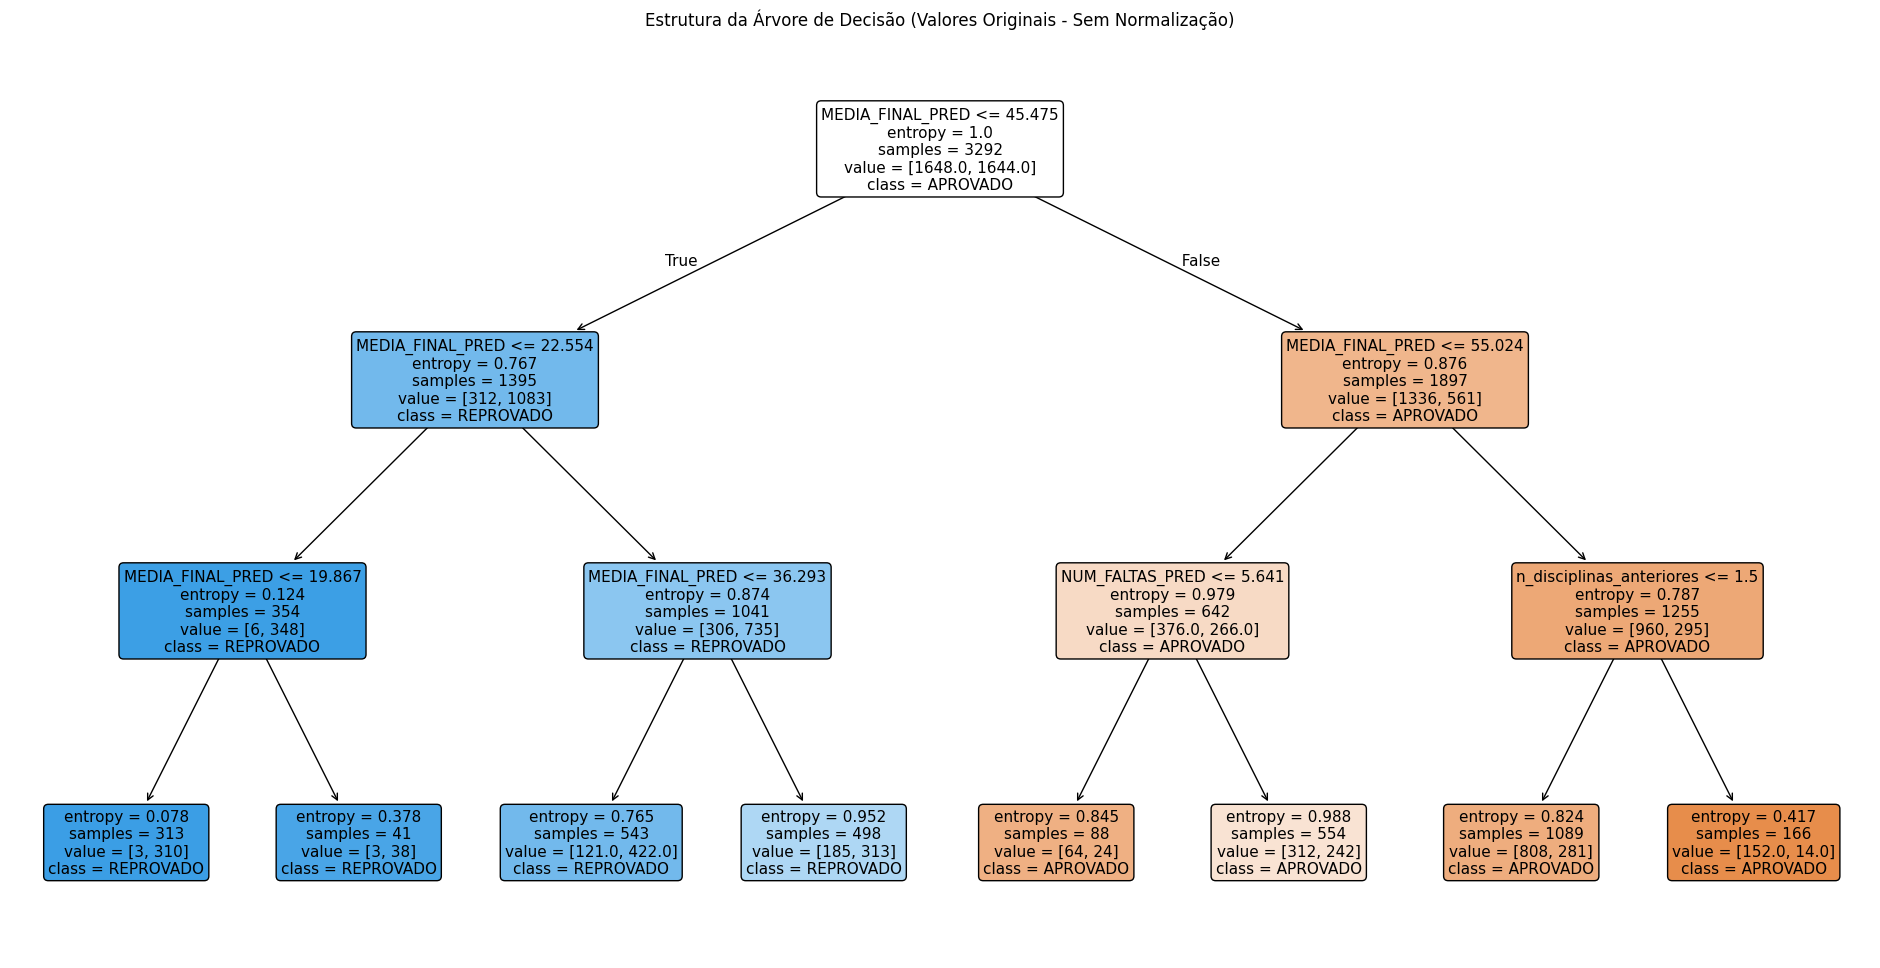


=== RESULTADOS DA ÁRVORE (VALIDAÇÃO CRUZADA K=10) ===
Acurácia: 0.7349 (+/- 0.0193)
F1-Score: 0.7331 (+/- 0.0195)
----------------------------------------
Acurácia em %: 73.49% (+/- 1.93%)
F1-Score em %: 73.31% (+/- 1.95%)


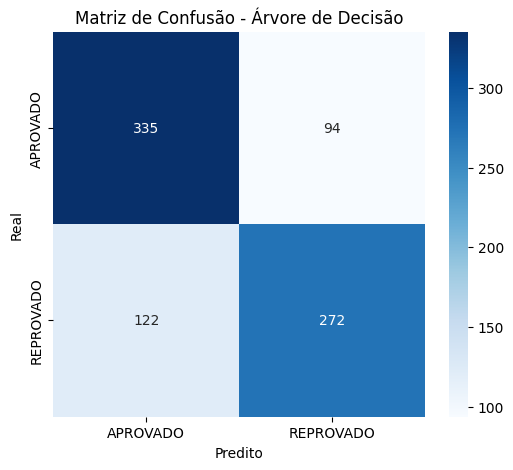

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# ==============================================================================
# 1. CARREGAR DADOS
# ==============================================================================
caminho_arquivo = '/content/drive/MyDrive/Facom/Doutorado/dados_disciplinas_processed.csv'
df = pd.read_csv(caminho_arquivo, sep=',')

# ==============================================================================
# 2. PRÉ-PROCESSAMENTO (SEM NORMALIZAÇÃO PARA ÁRVORE)
# ==============================================================================
df['disciplina_ja_cursada'] = df['disciplina_ja_cursada'].astype(int)

# Separar Features (X) e Target (y)
X_raw = df.drop(['MATR_ALUNO', 'TARGET'], axis=1)
y = df['TARGET']

# Divisão Treino/Teste (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# ==============================================================================
# 3. TREINAMENTO E PLOTAGEM DA ÁRVORE (VISUALIZAÇÃO)
# ==============================================================================
clf_tree_vis = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf_tree_vis.fit(X_train, y_train)

# Plotar a árvore
plt.figure(figsize=(24, 12))
plot_tree(clf_tree_vis,
          feature_names=X_raw.columns,
          class_names=clf_tree_vis.classes_,
          filled=True,
          rounded=True,
          fontsize=11)

plt.title("Estrutura da Árvore de Decisão (Valores Originais - Sem Normalização)")
plt.show()

# ==============================================================================
# 4. VALIDAÇÃO ROBUSTA (MÉDIA E DESVIO PADRÃO)
# ==============================================================================
print("\n=== RESULTADOS DA ÁRVORE (VALIDAÇÃO CRUZADA K=10) ===")

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

modelo_arvore = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

scores_acc = cross_val_score(modelo_arvore, X_raw, y, cv=kfold, scoring='accuracy')

scores_f1 = cross_val_score(modelo_arvore, X_raw, y, cv=kfold, scoring='f1_macro')

# --- CÁLCULO EXPLÍCITO DAS MÉDIAS E DESVIOS PADRÃO ---
acc_media = scores_acc.mean()
acc_std = scores_acc.std()

f1_media = scores_f1.mean()
f1_std = scores_f1.std()

# Exibir resultados formatados (Perfeito para copiar para o LaTeX)
print(f"Acurácia: {acc_media:.4f} (+/- {acc_std:.4f})")
print(f"F1-Score: {f1_media:.4f} (+/- {f1_std:.4f})")
print("-" * 40)
print(f"Acurácia em %: {acc_media*100:.2f}% (+/- {acc_std*100:.2f}%)")
print(f"F1-Score em %: {f1_media*100:.2f}% (+/- {f1_std*100:.2f}%)")


# ==============================================================================
# 5. MATRIZ DE CONFUSÃO (GRÁFICO)
# ==============================================================================
modelo_arvore.fit(X_train, y_train)
y_pred = modelo_arvore.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=modelo_arvore.classes_,
            yticklabels=modelo_arvore.classes_)
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()